In [1]:
# Tombo library
from tombo import tombo_helper, tombo_stats, resquiggle
# matplotlib library
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from mpl_toolkits.mplot3d import Axes3D
# py3helpers
from py3helpers.classification import ClassificationMetrics
from py3helpers.utils import merge_lists
from py3helpers.seq_tools import ReferenceHandler

# Other common libraries
import pandas as pd
from sklearn.utils import assert_all_finite
from scipy import signal
from sklearn.linear_model import LinearRegression
from sklearn.metrics import auc

import numpy as np
# built in library
import os


In [2]:
HOME = "/Users/andrewbailey/CLionProjects/rrna_analysis" 
figures = os.path.join(HOME, "figures")
rh = ReferenceHandler("/Users/andrewbailey/CLionProjects/rrna_analysis/reference/yeast_25S_18S.fa")

IVT_vs_Nop58_GAL = os.path.join(HOME, "tombo/IVT_vs_Nop58_GAL.level_compare_sample.tombo.stats")


In [3]:
rrna_ref_name = "RDN18-1"
stats_files = [IVT_vs_Nop58_GAL]
min_dstat = 0.9
gap = 5
n_positions = {"RDN18-1": 36, 
               "RDN25-1": 73}


In [4]:
def plot_and_get_random_canonical_pos(rrna_ref_name, stats_files, min_dstat=0.9, gap=5, n_positions={"RDN18-1": 36, "RDN25-1": 73}):
    
    title = f"Histogram of per-position 1 - D-statistics: {rrna_ref_name}"

    fig = plt.figure(figsize=(20, 6))
    panel1 = plt.axes([0.1, 0.1, .8, .8])
    panel1.set_xlabel(f"{rrna_ref_name} Reference Positions")
    panel1.set_ylabel("1 - D-statistic")
    panel1.grid(color='black', linestyle='-', linewidth=1, alpha=0.5)

    panel1.set_title(label=title)

    for i in range(len(stats_files)):
        assert os.path.exists(stats_files[i])
        ts = tombo_stats.TomboStats(stats_files[i])
        for contig in ts:
            if contig[0] == rrna_ref_name and contig[1] == "+":
                all_data = contig[4]
                panel1.plot([x[1] for x in all_data], [x[0] for x in all_data])
                ok_positions = []
                skip = True
                counter = 0
                for x in all_data:
                    if x[0] >= min_dstat:
                        if skip and counter <= gap:
                            counter += 1
                            continue
                #         print("append")
                        ok_positions.append([x[1], x[0]])
                        skip = False
                        counter = 0
                    else:
                        if not skip:
                            for i in range(gap):
                                if ok_positions:
                                    ok_positions.pop()
                        skip = True

    for pos, level in ok_positions:
        if i == 0:
            panel1.plot(pos, level, color='r', linewidth=0, marker='o', ms=5, label=f"Canonical Positions on {rrna_ref_name}")
        else:
            panel1.plot(pos, level, color='r', marker='o')

    positions = np.random.choice(len(ok_positions), n_positions[rrna_ref_name])
    selected_positions = pd.DataFrame(ok_positions).iloc[positions]

    for index, row in selected_positions.iterrows():
        pos = row[0]
        level = row[1]

        if i == 0:
            panel1.plot(pos, level, color='g', linewidth=0, marker='o', ms=5, label=f"Random Canonical Positions on {rrna_ref_name}")
        else:
            panel1.plot(pos, level, color='g', marker='o')
    return selected_positions.sort_values(by=[0])


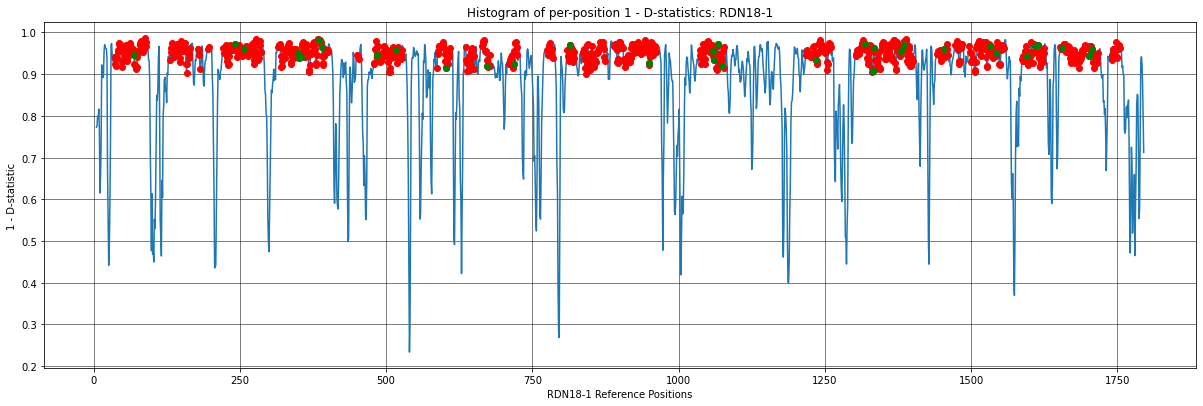

In [5]:
selected_positions_18 = plot_and_get_random_canonical_pos("RDN18-1", stats_files)


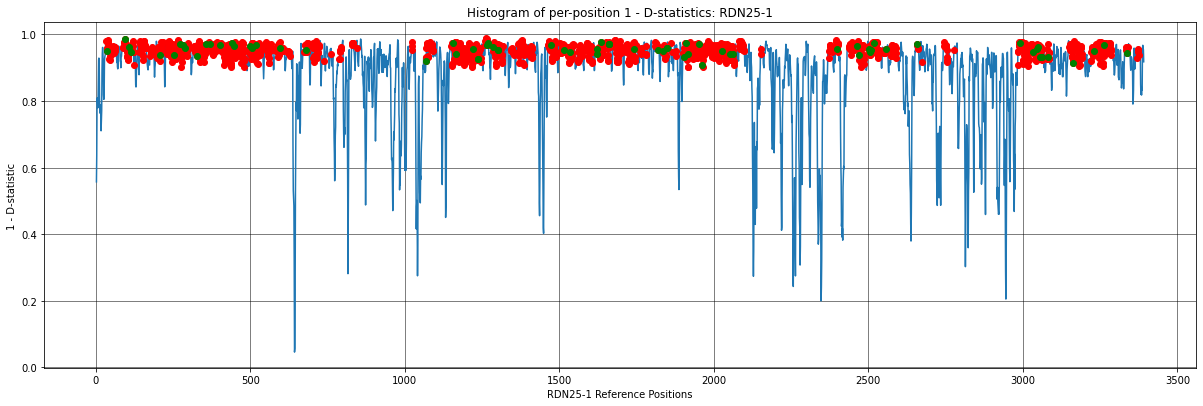

In [6]:
selected_positions_25 = plot_and_get_random_canonical_pos("RDN25-1", stats_files)


In [7]:
replace_bases = {"A": 'afj',
                 "T": 'dghlm',
                 "G": 'ck',
                 "C": 'bei'}




canonical_bases = {"A": 'n',
                   "T": 'q',
                   "C": 'o',
                   "G": 'p'}

c_positions = os.path.join(HOME, "reference/control_position_files/control_18S_25S_canonical.positions")
m_positions = os.path.join(HOME, "reference/control_position_files/control_18S_25S_modified.positions")
v_positions = os.path.join(HOME, "reference/control_position_files/control_18S_25S_variants.positions")



with open(c_positions, 'w') as c, open(m_positions, 'w') as m, open(v_positions, 'w') as v:
    for index, row in selected_positions_18.iterrows():
        pos = row[0]
        level = row[1]
        ref_base = rh.get_sequence("RDN18-1", pos, pos+1)
        rep_base = np.random.choice(list(replace_bases[ref_base]), 1)[0]
        variant = ref_base+rep_base
        c_base = canonical_bases[ref_base]
        
        print("\t".join([rrna_ref_name, str(int(pos)), "+", ref_base, rep_base]), file=m)
        print("\t".join([rrna_ref_name, str(int(pos)), "+", ref_base, variant]), file=v)
        print("\t".join([rrna_ref_name, str(int(pos)), "+", ref_base, c_base]), file=c)

        
    for index, row in selected_positions_25.iterrows():
        pos = row[0]
        level = row[1]
        ref_base = rh.get_sequence("RDN25-1", pos, pos+1)
        rep_base = np.random.choice(list(replace_bases[ref_base]), 1)[0]
        variant = ref_base+rep_base
        c_base = canonical_bases[ref_base]
        
        print("\t".join([rrna_ref_name, str(int(pos)), "+", ref_base, rep_base]), file=m)
        print("\t".join([rrna_ref_name, str(int(pos)), "+", ref_base, variant]), file=v)
        print("\t".join([rrna_ref_name, str(int(pos)), "+", ref_base, c_base]), file=c)

        